### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

Удержание состоит из следующих этапов:
1. определить сегмент, кого удерживать (это как раз наша часть)

### Метрики удержания

- return rate (конверсия возврата)
- churn rate (конверсия оттока)
- N-day retention (удержание на день N)

return rate = (текущее количество активных пользователей из набора данных)/(общее количество пользователей из набора данных)*100

churn rate = (количество пользователей из набора данных, ушедших в отток)/(общее количество пользователей из набора данных)*100

"Базируясь на предположении, что модель машинного обучения сможет сегментировать пользователей на тех, кто уходит в отток и нет, <b>не превышая ошибку в X%</b>, мы предполагаем, что реализовав такую систему прогнозирования вероятности оттока, основанную на ML, мы сможем выделить сегмент пользователей, которые собираются уйти в отток и провести кампанию по удержанию, что приведет к тому, что большинство таких пользователей останутся с нами в будущем. Мы увидим это по <b>увеличению доли пользователей, оставшихся с нами на день N</b> ,и можем измерить ее с помощью метрики <b>удержание N-го дня</b>. Мы полагаем, что изменение приведет к хорошим результатам для компании, т.к увеличит удержание пользователей и, как следствие, увеличение выручки для компании"

### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [458]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [459]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [460]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

In [461]:
df = df.drop('CustomerId', 1)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [462]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные стандартизируем

In [463]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [464]:
df.head(3)

,RowNumber,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [465]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [466]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (стандартизируем признак Age)

In [467]:
Age =  Pipeline([
                ('selector', NumberSelector(key = 'Age')),
                ('standard', StandardScaler())
            ])
Age.fit(X_train)
Age.transform(X_test)#.head(3)

array([[-0.36637708],
       [ 0.11067641],
       [ 0.3014978 ],
       ...,
       [ 0.01526571],
       [-0.08014499],
       [-0.74801987]])

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [468]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))


In [469]:
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [470]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [471]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RFC = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth= None, max_features=0.5, min_samples_leaf=3, random_state = 42)),
])

In [472]:
#обучим наш пайплайн
pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [473]:
#наши прогнозы для тестовой выборки
preds_RFC = pipeline_RFC.predict_proba(X_test)[:, 1]
preds_RFC[:10]

array([0.335529  , 0.19039426, 0.08971429, 0.01883333, 0.00166667,
       0.75870854, 0.06538889, 0.07360714, 0.10802381, 0.81744048])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [474]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [475]:
#precision, recall, thresholds = precision_recall_curve(y_test, preds_RFC)
precision_RFC, recall_RFC, thresholds_RFC = precision_recall_curve(y_test, preds_RFC)

fscore_RFC = (2 * precision_RFC * recall_RFC) / (precision_RFC + recall_RFC)
# locate the index of the largest f score
ix = np.argmax(fscore_RFC)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.389431, F-Score=0.655, Precision=0.661, Recall=0.648


#### 1.Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [476]:
#1.1 CatBoost
from catboost import CatBoost
#from catboost import CatBoostClassifier

params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}

In [477]:
pipeline_CB = Pipeline([
    ('features',feats),
    ('classifier', CatBoost(params=None)),
])

In [478]:
#обучим наш пайплайн
pipeline_CB.fit(X_train, y_train)

Learning rate set to 0.055868
0:	learn: 0.3966779	total: 18.3ms	remaining: 18.3s
1:	learn: 0.3902954	total: 21.9ms	remaining: 10.9s
2:	learn: 0.3848880	total: 25ms	remaining: 8.3s
3:	learn: 0.3794969	total: 28.5ms	remaining: 7.09s
4:	learn: 0.3749911	total: 31ms	remaining: 6.17s
5:	learn: 0.3711989	total: 33.6ms	remaining: 5.56s
6:	learn: 0.3669321	total: 37.5ms	remaining: 5.31s
7:	learn: 0.3633193	total: 40.7ms	remaining: 5.05s
8:	learn: 0.3600454	total: 44.3ms	remaining: 4.87s
9:	learn: 0.3571144	total: 47.2ms	remaining: 4.67s
10:	learn: 0.3541849	total: 50ms	remaining: 4.49s
11:	learn: 0.3514884	total: 53.5ms	remaining: 4.41s
12:	learn: 0.3491329	total: 56ms	remaining: 4.25s
13:	learn: 0.3467474	total: 58.9ms	remaining: 4.15s
14:	learn: 0.3447838	total: 62.5ms	remaining: 4.11s
15:	learn: 0.3429333	total: 65ms	remaining: 4s
16:	learn: 0.3411667	total: 75.7ms	remaining: 4.38s
17:	learn: 0.3395429	total: 78ms	remaining: 4.25s
18:	learn: 0.3381850	total: 80.4ms	remaining: 4.15s
19:	lear

173:	learn: 0.3036781	total: 683ms	remaining: 3.24s
174:	learn: 0.3035085	total: 686ms	remaining: 3.23s
175:	learn: 0.3033894	total: 688ms	remaining: 3.22s
176:	learn: 0.3032826	total: 690ms	remaining: 3.21s
177:	learn: 0.3031757	total: 693ms	remaining: 3.2s
178:	learn: 0.3030549	total: 696ms	remaining: 3.19s
179:	learn: 0.3029651	total: 698ms	remaining: 3.18s
180:	learn: 0.3028658	total: 701ms	remaining: 3.17s
181:	learn: 0.3027744	total: 704ms	remaining: 3.16s
182:	learn: 0.3026849	total: 707ms	remaining: 3.15s
183:	learn: 0.3025909	total: 711ms	remaining: 3.15s
184:	learn: 0.3024604	total: 714ms	remaining: 3.14s
185:	learn: 0.3023483	total: 721ms	remaining: 3.16s
186:	learn: 0.3022054	total: 724ms	remaining: 3.15s
187:	learn: 0.3021000	total: 751ms	remaining: 3.24s
188:	learn: 0.3019952	total: 755ms	remaining: 3.24s
189:	learn: 0.3019302	total: 758ms	remaining: 3.23s
190:	learn: 0.3018336	total: 761ms	remaining: 3.22s
191:	learn: 0.3017547	total: 764ms	remaining: 3.22s
192:	learn: 0

354:	learn: 0.2870689	total: 1.37s	remaining: 2.49s
355:	learn: 0.2869589	total: 1.37s	remaining: 2.48s
356:	learn: 0.2868414	total: 1.37s	remaining: 2.47s
357:	learn: 0.2867538	total: 1.38s	remaining: 2.47s
358:	learn: 0.2866583	total: 1.39s	remaining: 2.48s
359:	learn: 0.2865399	total: 1.39s	remaining: 2.47s
360:	learn: 0.2864952	total: 1.39s	remaining: 2.46s
361:	learn: 0.2864343	total: 1.4s	remaining: 2.46s
362:	learn: 0.2863791	total: 1.4s	remaining: 2.45s
363:	learn: 0.2863010	total: 1.4s	remaining: 2.45s
364:	learn: 0.2862287	total: 1.4s	remaining: 2.44s
365:	learn: 0.2861980	total: 1.41s	remaining: 2.43s
366:	learn: 0.2860903	total: 1.42s	remaining: 2.44s
367:	learn: 0.2859903	total: 1.42s	remaining: 2.44s
368:	learn: 0.2859152	total: 1.42s	remaining: 2.43s
369:	learn: 0.2858296	total: 1.42s	remaining: 2.42s
370:	learn: 0.2857536	total: 1.43s	remaining: 2.42s
371:	learn: 0.2856722	total: 1.43s	remaining: 2.42s
372:	learn: 0.2855904	total: 1.43s	remaining: 2.41s
373:	learn: 0.28

518:	learn: 0.2748659	total: 1.97s	remaining: 1.82s
519:	learn: 0.2747925	total: 1.97s	remaining: 1.82s
520:	learn: 0.2747349	total: 1.98s	remaining: 1.81s
521:	learn: 0.2746639	total: 1.98s	remaining: 1.81s
522:	learn: 0.2745953	total: 1.98s	remaining: 1.81s
523:	learn: 0.2744591	total: 1.98s	remaining: 1.8s
524:	learn: 0.2743712	total: 1.99s	remaining: 1.8s
525:	learn: 0.2742697	total: 1.99s	remaining: 1.79s
526:	learn: 0.2742085	total: 1.99s	remaining: 1.79s
527:	learn: 0.2741184	total: 1.99s	remaining: 1.78s
528:	learn: 0.2740695	total: 2s	remaining: 1.78s
529:	learn: 0.2739892	total: 2s	remaining: 1.77s
530:	learn: 0.2739315	total: 2s	remaining: 1.77s
531:	learn: 0.2738429	total: 2s	remaining: 1.76s
532:	learn: 0.2737713	total: 2.01s	remaining: 1.76s
533:	learn: 0.2736693	total: 2.01s	remaining: 1.75s
534:	learn: 0.2735834	total: 2.01s	remaining: 1.75s
535:	learn: 0.2735041	total: 2.01s	remaining: 1.74s
536:	learn: 0.2734350	total: 2.02s	remaining: 1.74s
537:	learn: 0.2733658	tota

693:	learn: 0.2629336	total: 2.62s	remaining: 1.16s
694:	learn: 0.2628047	total: 2.63s	remaining: 1.15s
695:	learn: 0.2627535	total: 2.63s	remaining: 1.15s
696:	learn: 0.2627221	total: 2.63s	remaining: 1.15s
697:	learn: 0.2626502	total: 2.64s	remaining: 1.14s
698:	learn: 0.2625861	total: 2.64s	remaining: 1.14s
699:	learn: 0.2625197	total: 2.65s	remaining: 1.13s
700:	learn: 0.2624459	total: 2.65s	remaining: 1.13s
701:	learn: 0.2623672	total: 2.66s	remaining: 1.13s
702:	learn: 0.2623244	total: 2.67s	remaining: 1.13s
703:	learn: 0.2622717	total: 2.67s	remaining: 1.12s
704:	learn: 0.2621861	total: 2.67s	remaining: 1.12s
705:	learn: 0.2621330	total: 2.68s	remaining: 1.11s
706:	learn: 0.2620527	total: 2.68s	remaining: 1.11s
707:	learn: 0.2619729	total: 2.7s	remaining: 1.11s
708:	learn: 0.2619032	total: 2.7s	remaining: 1.11s
709:	learn: 0.2618511	total: 2.7s	remaining: 1.1s
710:	learn: 0.2618035	total: 2.7s	remaining: 1.1s
711:	learn: 0.2617791	total: 2.71s	remaining: 1.09s
712:	learn: 0.2616

879:	learn: 0.2525958	total: 3.31s	remaining: 452ms
880:	learn: 0.2525479	total: 3.31s	remaining: 448ms
881:	learn: 0.2525020	total: 3.32s	remaining: 444ms
882:	learn: 0.2524862	total: 3.32s	remaining: 440ms
883:	learn: 0.2524263	total: 3.32s	remaining: 436ms
884:	learn: 0.2523407	total: 3.33s	remaining: 432ms
885:	learn: 0.2522848	total: 3.33s	remaining: 428ms
886:	learn: 0.2522357	total: 3.33s	remaining: 424ms
887:	learn: 0.2521618	total: 3.33s	remaining: 421ms
888:	learn: 0.2521364	total: 3.34s	remaining: 417ms
889:	learn: 0.2520969	total: 3.34s	remaining: 413ms
890:	learn: 0.2520588	total: 3.34s	remaining: 409ms
891:	learn: 0.2520144	total: 3.34s	remaining: 405ms
892:	learn: 0.2519598	total: 3.35s	remaining: 401ms
893:	learn: 0.2518692	total: 3.36s	remaining: 399ms
894:	learn: 0.2518214	total: 3.38s	remaining: 397ms
895:	learn: 0.2517465	total: 3.4s	remaining: 394ms
896:	learn: 0.2516884	total: 3.4s	remaining: 391ms
897:	learn: 0.2516245	total: 3.41s	remaining: 387ms
898:	learn: 0.

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [481]:
#наши прогнозы для тестовой выборки
preds_CB = pipeline_CB.predict(X_test)
preds_CB[:10]

array([ 0.44792023,  0.22754235,  0.10595002,  0.06588037, -0.07703475,
        0.87984216,  0.02512816,  0.21190937,  0.26347244,  0.83034918])

In [482]:
precision_CB, recall_CB, thresholds_CB = precision_recall_curve(y_test, preds_CB)

fscore_CB = (2 * precision_CB * recall_CB) / (precision_CB + recall_CB)
# locate the index of the largest f score
ix = np.argmax(fscore_CB)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.643517, F-Score=0.565, Precision=0.847, Recall=0.424


In [415]:
#1.2 LogisticRegression
pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [416]:
#обучим наш пайплайн
pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [417]:
#наши прогнозы для тестовой выборки
preds_LR = pipeline_LR.predict_proba(X_test)[:, 1]
preds_LR[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [418]:
precision_LR, recall_LR, thresholds_LR = precision_recall_curve(y_test, preds_LR)

fscore_LR = (2 * precision_LR * recall_LR) / (precision_LR + recall_LR)
# locate the index of the largest f score
ix = np.argmax(fscore_LR)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.460157, F-Score=0.645, Precision=0.706, Recall=0.593


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

1.1 Precison показывает долю объектов, названных классификатором положительными и при этом действительно являющимися положительными. Recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Порог влияет на них через величину FP и FN. Т.е. при разном уровне порога, один и тот же объект может ошибочно указан как положительным (FP), так и нулевым (FN).
2. Можно, если свести FN к нулю (установить порог близким к 0). Precison будет принимать околонулевые значения.
3. Можно, если свести FP к нулю (установить порог близким к max). Recall будет принимать околонулевые значения.

Отрисуем матрицу ошибок

In [419]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1961   30]
 [ 297  212]]


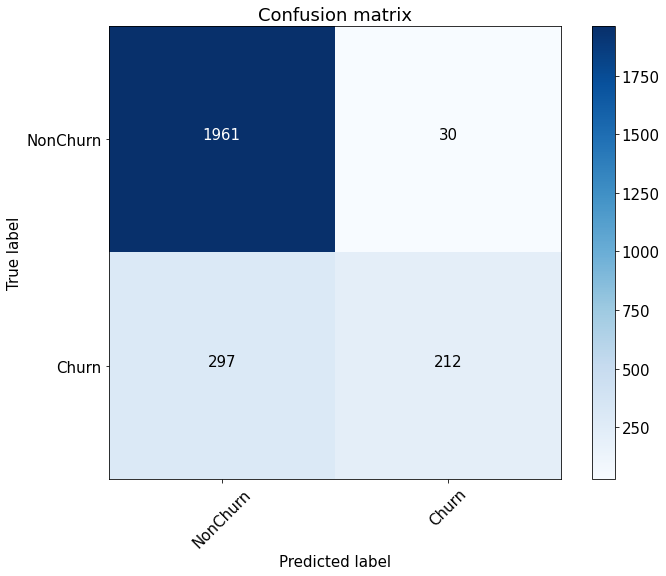

In [483]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_CB>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.643517 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

#### 3.Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар

#### Доход составит 1961 * 2 = 3922
#### Затраты составят 1961 + 30 = 1991
#### Прибыль 3922 - 1991 = 1931

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html
7. https://habr.com/ru/post/292312/
8. https://habr.com/ru/post/436236/
9. https://lifetimes.readthedocs.io/en/master/